<a href="https://colab.research.google.com/github/daveselinger/covid-19-hackathon/blob/master/by_state_covid_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Purpose**

The purpose of this analysis is to help people understand the severity of the COVID19 in a more realistic fashion.

We, the authors, believe that the analysis of COVID19 using national data is lacking in precision and actionability. Further, we feel that it may not be really representative of the "on-the-ground" experience: i.e., you can't average the experience of rural Montana with that of metropolitan Manhattan; or in fact even compare the metropolitan area of Seattle with that in San Diego.

**Open Source**

This code, its methodology, and conclusions are all released without any additional warranties or expectations using the MIT Open Source License.

**Social implications and responsibility**

While we are statisticians we recognize that there may be conclusions drawn from this analysis that have political and or personal ramifications for people. We therefore release this information to the open source with the best of intentions and with the hopes that these conclusions are used to save lives in a period of intense anxiety and volatility. In a world when it is hard to know "which facts" to believe, we have done everything we can to remove bias, to be explicit and transparent in the assumptions made and to be clear of our intent: We believe that more data will be better; we are disappointed in the lack of testing data -- and that is clear from our conclusions (these conslusions must be caveated with the fact that our model is affected by the variance because of the CDC's inability to test at the scale needed to face this problem); we believe that even with this volatility of data in a time of such dire consequences as has been proven in Wuhan China and Northern Italy, to not reach the best possible conclusions based on the data that we do have would be a dereliction of our duty and an act of ignorance. Therefore we submit this analysis and conclusions with nothing less than the best hopes for our citizens and with the desire for our local and state governments to do what is necessary regardless of any resistance they may face: We implore state health departments to act faster--even faster than the CDC and FDA might desire.


In [1]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
!pip install -U plotly
!pip install plotly-geo
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install chart-studio


--2020-03-23 21:55:02--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83339 (81K) [text/plain]
Saving to: ‘time_series_19-covid-Confirmed.csv.4’

time_series_19-covi 100%[===================>]  81.39K  --.-KB/s    in 0.03s   

2020-03-23 21:55:02 (2.75 MB/s) - ‘time_series_19-covid-Confirmed.csv.4’ saved [83339/83339]

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.5.4)


In [2]:
from __future__ import print_function

import numpy as np 
import chart_studio.plotly as py
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import datetime
import math
import scipy

pd.__version__


'0.25.3'

In [3]:
covid_across_countries_df = pd.read_csv('time_series_19-covid-Confirmed.csv')
global_timeseries = covid_across_countries_df.set_index(['Country/Region'])
global_timeseries.head(10)


,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Thailand,NaN,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411,599
Japan,NaN,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007,1086
Singapore,NaN,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432,455
Nepal,NaN,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
Malaysia,NaN,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183,1306
Canada,British Columbia,49.2827,-123.1207,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,4,4,4,4,4,4,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,9,12,13,21,21,27,32,32,39,46,64,64,73,103,103,186,231,271,424,424
Australia,New South Wales,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,533
Australia,Victoria,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,7,7,9,9,10,10,10,11,11,15,18,21,21,36,49,57,71,94,121,121,121,229,296
Australia,Queensland,-28.0167,153.4000,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,9,9,9,11,11,13,13,13,15,15,18,20,20,35,46,61,68,78,94,144,184,221,221


In [4]:
us_timeseries = global_timeseries.loc[['US']]
us_timeseries.head(5)

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,Washington,47.4009,-121.4905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,267,366,442,568,572,643,904,1076,1014,1376,1524,1793,1996
US,New York,42.1657,-74.9481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,220,328,421,525,732,967,1706,2495,5365,8310,11710,15793
US,California,36.1162,-119.6816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,177,221,282,340,426,557,698,751,952,1177,1364,1642
US,Massachusetts,42.2302,-71.5301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,95,108,123,138,164,197,218,218,328,413,525,646
US,Diamond Princess,35.4437,139.6380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,36,42,42,44,44,44,45,45,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,49,49,49


Now that we have the US data isloated, we can input this into a spatio-temporal map: Space represented as a map, and temporal as an animation.


In [5]:
!wget http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#
state_populations = pd.read_csv('nst-est2019-alldata.csv?', index_col='NAME')
state_populations.head(10)



URL transformed to HTTPS due to an HSTS policy
--2020-03-23 21:55:21--  https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?
Resolving www2.census.gov (www2.census.gov)... 23.76.87.160, 2600:1417:76:497::208c, 2600:1417:76:490::208c
Connecting to www2.census.gov (www2.census.gov)|23.76.87.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘nst-est2019-alldata.csv?.4’

nst-est2019-alldata     [ <=>                ]  72.35K  --.-KB/s    in 0.007s  

2020-03-23 21:55:21 (10.8 MB/s) - ‘nst-est2019-alldata.csv?.4’ saved [74085]



,SUMLEV,REGION,DIVISION,STATE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,BIRTHS2019,DEATHS2010,DEATHS2011,DEATHS2012,DEATHS2013,...,RDEATH2016,RDEATH2017,RDEATH2018,RDEATH2019,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
NAME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
United States,10,0,0,0,308745538,308758105,309321666,311556874,313830990,315993715,318301008,320635163,322941311,324985539,326687501,328239523,563561,2235208,2274116,2162725,2307293,2334155,2306148,2044228,1701962,1552022,987836,3973485,3936976,3940576,3963195,3992376,3962654,3901982,3824521,3791712,598691,2512442,2501531,2608019,...,8.400602,8.606413,8.668095,8.657569,4.706373,4.590575,4.231517,4.353645,4.045944,3.913875,3.438101,3.069450,2.921467,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
Northeast Region,20,1,0,0,55317240,55318443,55380134,55604223,55775216,55901806,56006011,56034684,56042330,56059240,56046620,55982803,61691,224089,170993,126590,104205,28673,7646,16910,-12620,-63817,163466,646249,637860,635751,632433,634504,628030,618490,610713,602740,110878,470811,460915,479963,...,8.574497,8.883355,8.975017,9.025986,3.161491,3.177337,2.789974,2.898189,2.593611,2.632618,2.151103,1.920274,1.734402,3.680555,3.681434,3.428960,3.931182,4.009115,4.177449,3.809171,3.195141,2.394817,-2.792646,-3.719789,-3.898743,-4.917279,-6.071080,-6.667933,-5.646219,-5.329588,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
Midwest Region,20,2,0,0,66927001,66929725,66974416,67157800,67336743,67560379,67745167,67860583,67987540,68126781,68236628,68329004,44691,183384,178943,223636,184788,115416,126957,139241,109847,92376,212570,834866,830701,830890,836538,838012,831641,818785,801587,792343,140862,586660,584671,605165,...,9.115871,9.409840,9.209377,9.121680,3.700916,3.658587,3.346624,3.542205,3.125649,3.127816,2.621003,2.547252,2.482162,1.713906,1.767566,1.845688,1.951908,2.070856,2.106735,1.825671,1.380898,1.254708,-2.677835,-2.741509,-1.852612,-2.714878,-3.459293,-3.348519,-2.383041,-2.303653,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
South Region,20,3,0,0,114555744,114563030,114866680,116006522,117241208,118364400,119624037,120997341,122351760,123542189,124569433,125580448,303650,1139842,1234686,1123192,1259637,1373304,1354419,1190429,1027244,1011015,368759,1509634,1504955,1504774,1525313,1545679,1541412,1519344,1494950,1481244,228435,963051,960791,1011227,...,8.695993,8.884440,9.003440,8.971661,4.734919,4.665975,4.189603,4.363271,4.101489,3.972326,3.473278,3.047185,2.871191,2.422447,2.898420,2.745376,3.013508,3.507594,3.521386,3.220112,2.415429,1.942372,2.708067,2.952037,2.546697,3.147993,3.769765,3.628688,2.978056,2.810090,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
West Regio

Get append data including population, hospitals, hospital beds.

In [6]:
#Need these abbreviations because Plotly requires 2-letter state abbreviations.

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

# filter out some of the states in the state_populations like the Diamond Princess
good_states = state_populations.index.intersection(us_state_abbrev.keys())

us_state_pop = {}
for state_name in good_states:
  state_row = state_populations.loc[state_name]
  us_state_pop[state_name]=state_row["POPESTIMATE2019"]

print (us_state_pop)

{'Alabama': 4903185, 'Alaska': 731545, 'Arizona': 7278717, 'Arkansas': 3017804, 'California': 39512223, 'Colorado': 5758736, 'Connecticut': 3565287, 'Delaware': 973764, 'District of Columbia': 705749, 'Florida': 21477737, 'Georgia': 10617423, 'Hawaii': 1415872, 'Idaho': 1787065, 'Illinois': 12671821, 'Indiana': 6732219, 'Iowa': 3155070, 'Kansas': 2913314, 'Kentucky': 4467673, 'Louisiana': 4648794, 'Maine': 1344212, 'Maryland': 6045680, 'Massachusetts': 6892503, 'Michigan': 9986857, 'Minnesota': 5639632, 'Mississippi': 2976149, 'Missouri': 6137428, 'Montana': 1068778, 'Nebraska': 1934408, 'Nevada': 3080156, 'New Hampshire': 1359711, 'New Jersey': 8882190, 'New Mexico': 2096829, 'New York': 19453561, 'North Carolina': 10488084, 'North Dakota': 762062, 'Ohio': 11689100, 'Oklahoma': 3956971, 'Oregon': 4217737, 'Pennsylvania': 12801989, 'Rhode Island': 1059361, 'South Carolina': 5148714, 'South Dakota': 884659, 'Tennessee': 6829174, 'Texas': 28995881, 'Utah': 3205958, 'Vermont': 623989, 'Vi

**Hospitals**

Next we analyze hospitals. We use data from [ArcGIS OpenData](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals/data) but for some reason I couldn't download this using a link, so I pulled it into Github and just stored it there.

**Assumptions**

These data have 2-3 key assumptions made in the modeling:
1. We assume that the only beds that can be used for ICU are in the "General Acute Care" class of hospital.
2. We assume that ICU beds comprise approximately 15%. We did not find a data set containing ICU details per state. This was based on an article from the NIH here: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5520980/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5520980/)

In [7]:
hospital_beds_df = pd.read_csv('https://raw.githubusercontent.com/daveselinger/covid-19-hackathon/master/Hospitals.csv')
hospital_beds_df.replace(to_replace=-999, value=1, inplace=True)
print (hospital_beds_df.set_index('STATE').loc['AK'].head(5))
print (hospital_beds_df.groupby('TYPE').sum())

hospital_beds_df.index.value_counts()

hospital_bed_count_df = hospital_beds_df.where(hospital_beds_df['TYPE'] == "GENERAL ACUTE CARE").groupby('STATE')['BEDS'].sum()

                X          Y  OBJECTID  ...  BEDS    TRAUMA HELIPAD
STATE                                   ...                        
AK    -151.077827  60.493169       635  ...   108  LEVEL II       Y
AK    -149.800293  61.182950       636  ...   148  LEVEL II       N
AK    -131.685788  55.353719       637  ...    54  LEVEL IV       Y
AK    -147.739393  64.831745       638  ...   217  LEVEL IV       Y
AK    -165.405315  64.501918       639  ...    36  LEVEL IV       N

[5 rows x 33 columns]
                                X              Y  ...  TTL_STAFF    BEDS
TYPE                                              ...                   
CHILDREN            -11434.801713    4568.912875  ...        124   16853
CHRONIC DISEASE       -660.310220     369.804715  ...          9    1414
CRITICAL ACCESS     -99135.887396   41965.188956  ...       1031   27440
GENERAL ACUTE CARE -415767.410650  167018.239174  ...       4524  831577
LONG TERM CARE      -39202.381094   15554.476288  ...        43

**Computing State-by-State Statistics**

Some key assumptions in computing these data:
- 40% of cases will need hospitalization
- 15% of cases will need an ICU
- ICU's are 15% of total beds in a hospital
- 90% of the cases are in the key metropolitan area of the state (which is where the outbreak will occur in a state most likely due to virality/spread -- this is NOT ACTUALLY the case if we had metro/county level data which would be much more accurate)
- 40% of the population (and importantly here hospital beds/icu beds) are in this metropolitan areas

**Key assumptions and the desire to repeat this analysis with county-level data**

These last 2 assumptions are particularly important as the population-density of a state is not flat across its population. The most likely places for broadly spreading COVID are in places where many people are interacting frequently (i.e., metropolitan areas). Therefore, we have made the assumption that the case-incident data would reflect this distribution of cases. We chose 90% as an assumption based on the virulence and high R0 of this disease--the higher this value, the more exaggerated the impact of even a very few cases in a dense metro area. Furthermore, we estimate that only 40% of the population of a state lives in this based on an approximation from the WAPO combining "Metropolitan" and "Big City"
https://www.washingtonpost.com/business/2018/12/18/americans-say-theres-not-much-appeal-big-city-living-why-do-so-many-us-live-there/ (which indicates 12% big city, 21% big city suburb)

We recognize that these assumptions would be far better handled by having case data, hospital (& ICU data) and population by county, but those data were not available to the best of our knowledge.

In [8]:
GROWTH_RATE_MIN_THRESHOLD=100
days_to_fit=4
icu_case_ratio=0.15
days_in_ICU=14
invalid_date=datetime.date(2019,1,1)
def calcBaseGR(days):
  base_data=us_timeseries.iloc[:,51:51+days-1].sum()
  results=scipy.optimize.curve_fit(lambda day,gr: np.log(base_data[0])+np.log(gr)*day,  range(len(base_data)),  np.log(base_data),  p0=(2))
  #results=scipy.optimize.curve_fit(lambda day,gr: np.log(data[-days_to_fit])+np.log(gr)*day,  range(days_to_fit),  np.log(data[-days_to_fit:]),  p0=(2))
  base_GR=float(results[0][0])
  return base_GR,base_data

def create_dfs(enddate=datetime.datetime.today().date(),startdate=datetime.date(2020,3,10),case_concentration=1.0, population_concentration=1.0):
  ts=us_timeseries.reset_index()
  days=(enddate - startdate).days 
  base_GR,_=calcBaseGR(days)


  def func(data,base_GR):
    if data[-1]<GROWTH_RATE_MIN_THRESHOLD or len(data)<days_to_fit:
      return base_GR
    if np.any(data == 0):
      return base_GR
    logdata=[math.log(x) for x in data[-days_to_fit:]]
    fit=scipy.optimize.curve_fit(lambda day,gr: logdata[0]+np.log(gr)*day,  range(days_to_fit),  logdata,  p0=(1.0))
    return float(fit[0][0])
  growth_df=pd.DataFrame({"state_name":ts.loc[:,'Province/State'],
                    'GR':ts.apply(lambda x: func(x.iloc[51+days-days_to_fit:51+days].to_numpy(),base_GR),axis=1),
                    'Count':ts.iloc[:,51+days-1]})
  
  growth_df['State'] = growth_df.state_name.map(us_state_abbrev)
  growth_df = growth_df.dropna(subset=['State'])
  growth_df['Growth Rate']=(growth_df.GR-1)*100
  growth_df['Days to Double'] = np.log(2)/np.log(growth_df.GR)
  growth_df['Population'] = growth_df.state_name.map(us_state_pop)
  growth_df['Beds'] = growth_df.State.map(hospital_bed_count_df)
  growth_df['Beds Percent'] = growth_df.Beds
  beds_in_metro = growth_df.Beds * population_concentration
  growth_df['Population Percent (1/100 of 1%)'] = growth_df.Count * 10000.0 / growth_df.Population
  cases_needing_beds_in_metro = growth_df.Count * case_concentration * .4
  growth_df['Beds Percent'] = cases_needing_beds_in_metro * 100.0 / (beds_in_metro)
  growth_df['ICU'] = growth_df.Beds * icu_case_ratio
  growth_df['Beds per 1000'] = 1000.0 * growth_df.Beds / growth_df.Population
  cases_needing_icu_in_metro = growth_df.Count * case_concentration * .15
  icu_beds_in_metro = growth_df.ICU * population_concentration
  growth_df['ICU Percent'] = cases_needing_icu_in_metro * 100.0 / (icu_beds_in_metro)
  multiplier_to_fill_icu = 1.0 / (growth_df['ICU Percent']/100)
  growth_df['Days To ICU Capacity']=np.log(multiplier_to_fill_icu)/np.log(growth_df.GR)
  growth_df['Beds per 1000'] = 1000.0 * growth_df.Beds / growth_df.Population
  growth_df['EstimateDate']=enddate
  valid_dates=np.isfinite(growth_df['Days To ICU Capacity'])
  def func(days):
    return enddate+datetime.timedelta(days=int(days))
  growth_df['ICU Full Date']=growth_df[valid_dates].apply(lambda x: func(x['Days To ICU Capacity']),axis=1)
  growth_df['FirstDataDate']=startdate
  return  growth_df

def create_plot_dfs(enddate=datetime.datetime.today().date(),startdate=datetime.date(2020,3,10),threshold=None):
  ts=us_timeseries.reset_index()
  plot_df=ts.melt(id_vars=['Province/State'],var_name="Day",value_vars=ts.columns[52:],value_name="Count")
  plot_df=plot_df.rename(columns={'Province/State':'State'})
  if threshold is not None:
    plot_df=plot_df[plot_df.Count>threshold]
  plot_df['State']=plot_df.State.map(us_state_abbrev)
  plot_df['Day']=plot_df.Day
  plot_df['Date']=pd.to_datetime(plot_df.Day)
  return plot_df

us_growthseries_df=create_dfs()
us_plotseries_df=create_plot_dfs()
us_plot100series_df=create_plot_dfs(threshold=100)
us_growthseries_df.head(1)

,state_name,GR,Count,State,Growth Rate,Days to Double,Population,Beds,Beds Percent,Population Percent (1/100 of 1%),ICU,Beds per 1000,ICU Percent,Days To ICU Capacity,EstimateDate,ICU Full Date,FirstDataDate
0,Washington,1.224033,1793,WA,22.403254,3.428862,7614893.0,11292.0,6.351399,2.354596,1693.8,1.482884,15.878498,9.103128,2020-03-23,2020-04-01,2020-03-10


Verify that growth rate estimation looks reasonable

Growth rate = 1.75


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



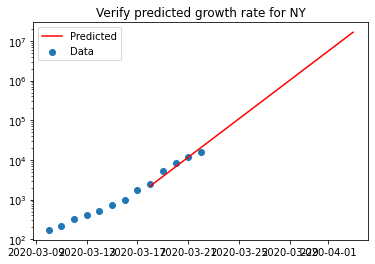

In [9]:
predictdays=14
state='NY'
cdata=us_plotseries_df.query("State=='{}'".format(state))
crow=us_growthseries_df.query("State=='{}'".format(state))
startdate=crow.EstimateDate.values[0]-datetime.timedelta(days=days_to_fit+1)
enddate=startdate+datetime.timedelta(days=predictdays-1+days_to_fit-1)
daterange=pd.date_range(startdate,enddate).tolist()
print("Growth rate = {:.2f}".format(crow.GR.values[0]))
data=[crow.Count.values[0]*pow(crow.GR.values[0],d) for d in range(1-days_to_fit,predictdays)]
plt.figure()
plt.scatter(cdata.Date.values,cdata.Count.values,label='Data')
plt.plot(daterange,data,label='Predicted',c='r')
plt.title("Verify predicted growth rate for {}".format(state))
plt.yscale('log')
plt.legend()
plt.show()

The following shows the predicted data of ICU becoming full. This demonstrates the stability of the prediction.

In [0]:
state_df=pd.DataFrame(create_dfs()['State'])
daterange=pd.date_range(datetime.date(2020,3,14),pd.datetime.today()).tolist()[:-1]
for dt in  daterange:
  df2=create_dfs(enddate=dt.date())
  df2[df2.Count<50]=None
  state_df[dt]=df2['ICU Full Date']

In [11]:
max_days=20
df2=state_df.melt(id_vars=['State'],var_name="predicted",value_name="ICUFull").dropna(subset=['ICUFull'])
px.line(df2,x="predicted",y="ICUFull",line_group="State",color="State",).update_layout(
    title="Predicted ICU Full",
    xaxis_title="Date of Prediction",
    yaxis_title="Predicted ICU Full date",
    )

In [12]:
# Generate dataframe for since reaching 100
case_concentration=1.0
population_concentration=1.0
ratio=icu_case_ratio*case_concentration/population_concentration

base_GR=1.3
def fit_gr(data):
  if data[-1]<GROWTH_RATE_MIN_THRESHOLD:
    return base_GR
  if np.any(data == 0) or len(data)<2:
    return base_GR
  logdata=[math.log(x) for x in data]
  fit=scipy.optimize.curve_fit(lambda day,gr: logdata[0]+np.log(gr)*day,  range(len(data)),  logdata,  p0=(1.0))
  return float(fit[0][0])


gmap=us_growthseries_df.set_index('State')
tmp_df=us_plot100series_df.copy()
broke100df=tmp_df.groupby('State').min()
startdate64=np.datetime64(datetime.date(2020,3,10))
broke100df['offset']=broke100df.Date-startdate64
smap=broke100df.to_dict()['Date']
tmp_df['tmp']=tmp_df.apply(lambda x: smap[x.State],axis=1)
tmp_df['days_since_100']=tmp_df.apply(lambda x:int((x.Date-smap[x.State]).days),axis=1)
since100_df=tmp_df.loc[:,['State','days_since_100','Count']].reset_index()#.groupby('State')#.sort_values(by=['days_since_100'])
since100_df["ICUFraction"]=since100_df.Count.to_numpy()*ratio/gmap.loc[since100_df.State].ICU.to_numpy()
since100_df["PopulationPercent"]=since100_df.Count.to_numpy()/gmap.loc[since100_df.State].Population.to_numpy()*100
since100_df['GR'] = since100_df.groupby('State')['Count'].rolling(3,min_periods=1).apply(fit_gr,raw=True).reset_index(0,drop=True)
since100_df.tail(30)


,index,State,days_since_100,Count,ICUFraction,PopulationPercent,GR
133,2965,NY,12,15793,0.302733,0.081183,1.659281
134,2966,CA,12,1642,0.018677,0.004156,1.223651
135,2967,MA,10,646,0.042595,0.009373,1.335018
136,2970,GA,6,600,0.024937,0.005651,1.353472
137,2971,CO,8,476,0.056552,0.008266,1.297950
138,2972,FL,7,830,0.013999,0.003864,1.286750
139,2973,NJ,6,1914,0.076670,0.021549,1.711388
140,2974,OR,2,161,0.023053,0.003817,1.148070
141,2975,TX,5,627,0.009181,0.002162,1.435170
142,2976,IL,6,1049,0.034311,0.008278,1.682411


In [13]:
max_days=20

px.line(since100_df,x="days_since_100",y="Count",line_group="State",color="State",log_y=True,
            title="Case Count by State").update_layout(
            xaxis_title="Days Since 100 Cases",
            yaxis_title="Total Cases",
            ).update_xaxes(range=(0,max_days)).show()

In [14]:
v=since100_df['PopFrac']=since100_df['PopulationPercent']/100
px.line(since100_df,x="days_since_100",y=v,line_group="State",color="State",log_y=True,
            title="Fraction of population infected by State").update_layout(
            xaxis_title="Days Since 100 Cases",
            yaxis_title="Fraction of population infected",
            ).update_xaxes(range=(0,max_days)).show()

In [15]:
options=", {:.0f}% of cases require ICU, {} days in ICU".format(icu_case_ratio*100,days_in_ICU,)
px.line(since100_df,x="days_since_100",y="ICUFraction",line_group="State",color="State",log_y=True,
            title="ICU Fractional by State"+options).update_layout(
            xaxis_title="Days Since 100 Cases",
            yaxis_title="Fraction of ICU required",
            ).update_xaxes(range=(0,max_days)).update_yaxes(range=(-3,0.3)).show()

In [0]:

#TODO: Update this daily, and figure out if we can easily publish this to the web and update a website daily.
#TODO: Add the ability now to plot the growth curve of states like https://colab.research.google.com/github/machine-learning-apps/covid19-dashboard/blob/master/_notebooks/2020-03-14-covid19_growth.ipynb


In [16]:
colorscale = px.colors.sequential.Blues_r
reverse_colorscale = colorscale [::-1]
fig = px.choropleth(us_plotseries_df, title = "Cases", locations="State", locationmode="USA-states",scope="usa", color="Count", animation_frame="Day", range_color=[0,250], color_continuous_scale=colorscale)
fig.show()



In [17]:
fig2 = px.choropleth(us_growthseries_df, title="Growth Rate", locations="State", locationmode="USA-states",scope="usa", color="Growth Rate", range_color=[0,50], color_continuous_scale=colorscale)
fig2.show()


In [18]:
fig3 = px.choropleth(us_growthseries_df, title="Days to Double", locations="State", locationmode="USA-states",scope="usa", color="Days to Double", range_color=[0,10], color_continuous_scale=reverse_colorscale)
fig3.show()


In [19]:
fig4 = px.choropleth(us_growthseries_df, title="Percent Infected (bps)", locations="State", locationmode="USA-states",scope="usa", color="Population Percent (1/100 of 1%)", range_color=[0,1], color_continuous_scale=colorscale)
fig4.show()


In [20]:
fig4a = px.choropleth(us_growthseries_df, title="Hospital Beds Per Capita (1000 people)", locations="State", locationmode="USA-states",scope="usa", color="Beds per 1000", range_color=[0,10], color_continuous_scale=colorscale)
fig4a.show()


In [21]:
fig5 = px.choropleth(us_growthseries_df, title="Percent of Beds (%)", locations="State", locationmode="USA-states",scope="usa", color="Beds Percent", range_color=[0,50], color_continuous_scale=colorscale)
fig5.show()


In [22]:
fig6 = px.choropleth(us_growthseries_df, title="Percent of ICU Beds (%)", locations="State", locationmode="USA-states",scope="usa", color="ICU Percent", range_color=[0,50], color_continuous_scale=colorscale)
fig6.show()


In [23]:
fig7 = px.choropleth(us_growthseries_df, title="Days to fill ICU", locations="State", locationmode="USA-states",scope="usa", color="Days To ICU Capacity", range_color=[0,50], color_continuous_scale=colorscale)
fig7.show()

```
DaysInICU=14 days in ICU
needICU = 15% of infected
infected after DaysInICU days= infected* GR**DaysInICU
newly infected= infected*GR**DaysInICU - infected
newly need ICU = newly_infected*needICU
infected=ICUBeds/needICU
ICUBeds=(infected)*(GR**DaysInICU-1)*needICU
ICUBeds=(ICUBeds/needICU)*(GR**DaysInICU-1)*needICU
1=GR**DaysInICU-1
GR=exp(log(2)/DaysInICU)
```


In [24]:
days_in_ICU=14
# Critical GrowthRate (GR) is the steady state infection growth rate to keep the ICU load constant
# it is independent of state o
print("Critical growth rate = {:.2f}%".format(100*(np.exp(np.log(2)/days_in_ICU)-1))
)

Critical growth rate = 5.08%


Next, let's compute a simulation to determine what the GrowthRate (GR) we need for this state to NOT overwhelm the ICU.
This simulation will have to be done including  assumed length of stay in the ICU (14 days for now--can correct if we need to) (people in then people out).


*   What does GR need to be tomorrow to get the number of days to 60?
*   What if we double the number ICU-capable beds?
*   Ensure we keep the # of days in the ICU as a variable.


In [25]:
us_growthseries_df.sort_values('Days To ICU Capacity')[['State', 'Count','Growth Rate', 'Days To ICU Capacity']]

,State,Count,Growth Rate,Days To ICU Capacity
1,NY,11710,74.697658,2.678010
44,MI,788,134.528344,4.031506
9,NJ,1327,80.145537,4.985626
12,IL,753,78.793349,6.374220
18,TN,371,70.512630,7.676365
31,CT,194,54.508984,8.725214
0,WA,1793,22.403254,9.103128
40,AR,122,61.248247,9.121386
20,AZ,118,65.546095,9.272850
24,NV,161,45.254989,9.440053


Compute how effective Italian measures were in impacting growth rates

In [26]:
italy_timeseries=global_timeseries.loc[['Italy']]
#italy_timeseries.loc[:,'3/10/20':'3/15/20']
italy_timeseries


,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Italy,NaN,43.0,12.0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138


In [27]:
#TODO: Add fit-by-date

growth_rates = []
last_count = 0
enddate = datetime.date(2020,3,18)
startdate = datetime.date(2020,2,10)
days = (enddate - startdate).days + 1
for date in (startdate + datetime.timedelta(n) for n in range(days)):
  datestr = "" + str(date.month) + "/" + str(date.day) + "/" + str(date.year)[2:]
  count = italy_timeseries.get(datestr)
  italy_growth = 0.0
  if last_count > 0:
    italy_growth = 1.0 * int(count) /last_count - 1
  
  last_count = int(count)
  growth_rates.append([date, int(count), italy_growth])
growth_rates
italy_df = pd.DataFrame(data=growth_rates, columns=['Date', 'Count', 'Growth Rate'])
fig2 = px.line(data_frame=italy_df, x= 'Date', y='Count', title="Italian Count")
fig2.show()
fig3 = px.line(data_frame=italy_df, x= 'Date', y='Growth Rate', title="Italian Growth Rate")
fig3.update_yaxes(range=[0, 1])
fig3.show()